In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_mias_mammography_path = kagglehub.dataset_download('kmader/mias-mammography')
martholi_inbreast_path = kagglehub.dataset_download('martholi/inbreast')
cheddad_miniddsm_path = kagglehub.dataset_download('cheddad/miniddsm')
tommyngx_inbreast2012_path = kagglehub.dataset_download('tommyngx/inbreast2012')
tommyngx_mias2015_path = kagglehub.dataset_download('tommyngx/mias2015')
nguynththanhho_breastcancer_path = kagglehub.dataset_download('nguynththanhho/breastcancer')

print('Data source import complete.')


In [ ]:
import numpy as np
import cv2
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torchvision.io import read_image
import matplotlib.pyplot as plt
import pydicom
import torch

In [ ]:
import os, sys, tarfile

def extract(tar_url, extract_path='.'):
    print (tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])
try:
    extract("../input/inbreast/inbreast.tgz")
    print ('Done.')
except:
    name = os.path.basename(sys.argv[0])
    print (name[:name.rfind('.')], '<filename>')

../input/inbreast/inbreast.tgz
Done.


In [ ]:
# from torchvision.io import read_image
# import matplotlib.pyplot as plt
# import pydicom
# import torch
# import numpy as np
# %matplotlib inline
# path_inbreast = "./ALL-IMGS/22670094_e1f51192f7bf3f5f_MG_R_CC_ANON.dcm"
# def read_img(path):
#     img = pydicom.dcmread(path)
#     img = np.array(img.pixel_array, dtype = np.float32)
#     img = torch.from_numpy(img)
#     return img, img.shape
# img, shap = read_img(path_inbreast)

# plt.imshow(img)
# # im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
# #                  extent=extent)

# plt.show()

# Class dataset

In [ ]:
import imghdr
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pydicom
import os
import numpy as np
import pandas as pd

class INBreastDataset(Dataset):
    def __init__(self, root, img_dir):
        self.img_dir = img_dir
        self.img_data = pd.read_csv(img_dir)

    def __len__(self):
        return len(self.img_data['Lesion Annotation Status'])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_data.iloc[idx, 0])
        img = pydicom.dcmread(img_path)
        img = np.array(img.pixel_array, dtype = np.float32)
        img = torch.from_numpy(img)
        label = self.img_data['Lesion Annotation Status'][idx]
        return img, label

In [ ]:
root = "./ALL-IMGS"
train_dir = "../input/breastcancer/INBreast_config.csv"
train_dataset = INBreastDataset(root, train_dir)
len(train_dataset)

410

# MIAS with point cancer

In [ ]:
# ls = []
# with open("../input/mias-mammography/Info.txt", "r") as f:
#     ls = f.read().split('\n')
#     f.close()
# # ls

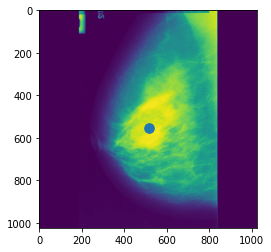

In [ ]:
from skimage.io import imread
r = 'mdb315 D CIRC B 516 447 93'
image = imread("../input/mias-mammography/all-mias/mdb315.pgm")
a = torch.from_numpy(image)
plt.imshow(a)
plt.scatter(516, 1000-447, s=93)

# load_inbreast_mask

In [ ]:
from skimage.draw import polygon
import numpy as np
import plistlib

def load_inbreast_mask(mask_path, imshape=(3328, 2560)):
    """
    Hàm này dùng để đọc file XML
    @mask_path : Path tới file XML
    @imshape : shape của ảnh đầu ra vd. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [load_point(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[0]), int(point[1])] = 1
            else:
                x, y = zip(*points)
                x, y = np.array(x), np.array(y)
                poly_x, poly_y = polygon(x, y, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

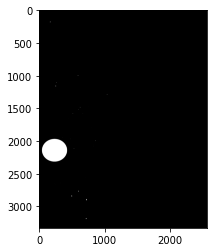

In [ ]:
a = load_inbreast_mask("/kaggle/input/inbreast2012/INbreast Release 1.0/AllXML/20586934.xml",  (3328,2560))
plt.imshow(a,cmap='gray')

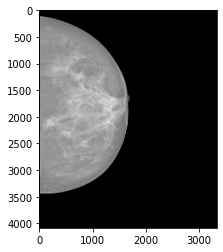

In [ ]:
%matplotlib inline
path_inbreast = "/kaggle/input/inbreast2012/INbreast Release 1.0/AllDICOMs/20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm"
def read_img(path):
    img = pydicom.dcmread(path)
    img = np.array(img.pixel_array, dtype = np.float32)
    img = torch.from_numpy(img)
    return img, img.shape
img, im_shap = read_img(path_inbreast)
# p = img + a
plt.imshow(img , cmap='gray')
# im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
#                  extent=extent)

plt.show()
# print(img.shape)

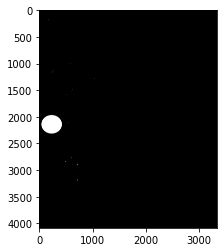

In [ ]:
a = load_inbreast_mask("/kaggle/input/inbreast2012/INbreast Release 1.0/AllXML/20586934.xml", img.shape)
plt.imshow(a,cmap='gray')

In [ ]:
import cv2
from collections import Counter
from PIL import Image
img = pydicom.dcmread(path_inbreast)
img = np.array(img.pixel_array, dtype = np.int64)
# value_img, img_count = np.unique(img, return_counts=True)
# img_count = list(img_count)
# img_count.insert(0, 0)
# img_count = np.array(np.unique(img, return_counts=True))
# img_count_1 = [img_count[index] + img_count[index-1] for index, val in enumerate(img_count[1:])]
# img_count_1

In [ ]:
img.shape

(4084, 3328)

# CLAHE

In [ ]:
from torchvision.io import read_image

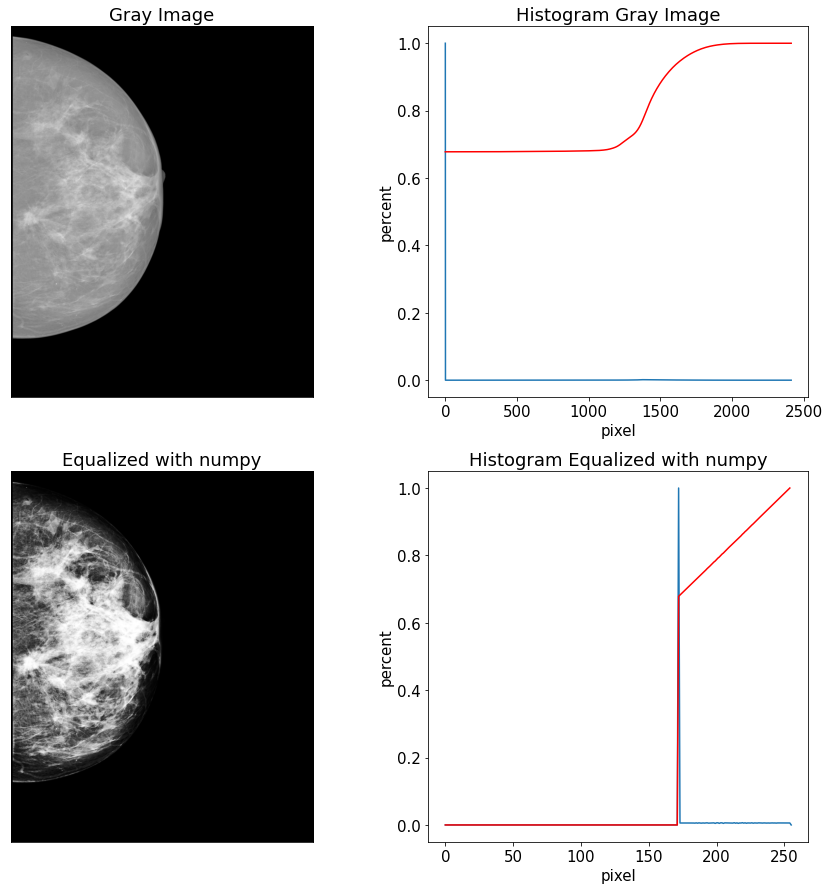

In [ ]:

plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (30, 10)
def show_hist(gray, equ, categori, cdf1 = [], cdf2 = []):
    m = int(np.max(img))
    f = plt.figure(figsize=(15, 15))
    f.add_subplot(2, 2, 1, xticks = [], yticks=[]).set_title('Gray Image')
    plt.imshow(gray, cmap = 'gray')
    f.add_subplot(2, 2, 2).set_title('Histogram Gray Image')
    histogram, bin_edges = np.histogram(gray, bins=m+1, range=(0, m+1))
    plt.plot(bin_edges[:-1], histogram/np.max(histogram))
    if len(cdf1) > 0:
        plt.plot(cdf1, color = 'red')
    plt.xlabel('pixel')
    plt.ylabel('percent')


    f.add_subplot(2, 2, 3, xticks = [], yticks=[]).set_title(f'{categori}')
    plt.imshow(equ, cmap = 'gray')
    f.add_subplot(2, 2, 4).set_title(f'Histogram {categori}')
    histogram, bin_edges = np.histogram(equ, bins=256, range=(0, 256))
    plt.plot(bin_edges[:-1], histogram/np.max(histogram))
    if len(cdf2) > 0:
        plt.plot(cdf2, color = 'red')
    plt.xlabel('pixel')
    plt.ylabel('percent')
    plt.show()

def get_cdf(img):
    m = int(np.max(img))
    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]
    hist = hist/img.size
    cdf = np.cumsum(hist)
    return cdf

# numpy
def histogram_equalization(img):
    m = int(np.max(img))
    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]
    # bước 1: tính pdf
    hist = hist/img.size
    # bước 2: tính cdf
    cdf = np.cumsum(hist)
    # bước 3: lập bảng thay thế
    s_k = (255 * cdf)
    # ảnh mới
    img_new = np.array([s_k[i] for i in img.ravel()]).reshape(img.shape)
    return img_new

gray2 = img
img_equ= histogram_equalization(gray2)
cdf1 = get_cdf(gray2)
cdf2 = get_cdf(img_equ)
show_hist(gray2, img_equ, 'Equalized with numpy', cdf1=cdf1, cdf2=cdf2)



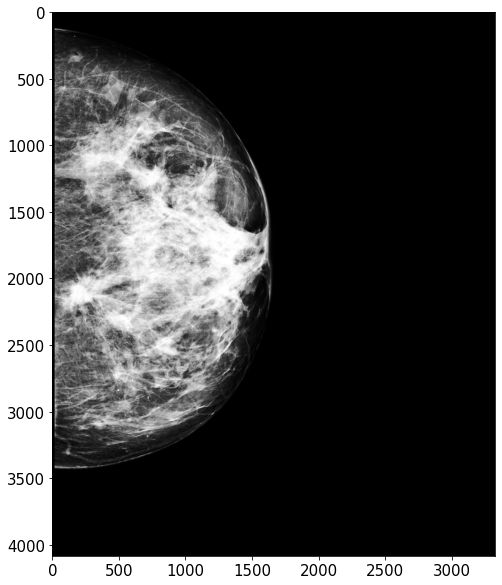

In [ ]:
plt.imshow(img_equ, cmap='gray')

# Crop image

In [ ]:
import numpy as np
import cv2
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [ ]:
def show(img, title = 'Gray Image', rgb = False, fs = 12, dp = (10, 10)):
    plt.rcParams.update({'font.size': fs})
    plt.rcParams['figure.figsize'] = dp
    if rgb:
        plt.imshow(img[:,:,::-1])
    else:
        plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'{title}')
    plt.show()

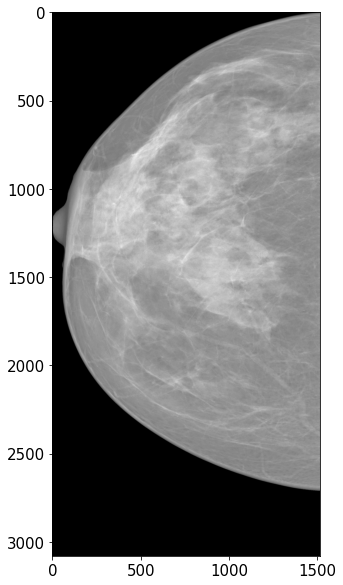

In [ ]:
def preprocess_before_crop(img):
    '''
        input: gray image
        dtype: np.array
    '''
    img_equ= histogram_equalization(img)
    threshold = filters.threshold_sauvola(img_equ)
    binary_img = (img_equ > threshold)*1
    kernel = np.ones((5, 5), np.uint8)
    binary_img = binary_img.astype('uint8')
    binary_img = cv2.erode(binary_img, kernel, iterations=-2)
    return binary_img

def crop_img(img):
    binary_img = preprocess_before_crop(img)
    farest_pixel = np.max(list(zip(*np.where(binary_img == 0))), axis=0)
    nearest_pixel = np.min(list(zip(*np.where(binary_img == 0))), axis=0)
    if(nearest_pixel[1] == 0):
        return img[:farest_pixel[0], :farest_pixel[1]]
    else:
        return img[nearest_pixel[0]:, nearest_pixel[1]:]
#     print(farest_pixel, nearest_pixel)
def show_img(img):
    plt.imshow(img, cmap = "gray")

path_img_l = "/kaggle/working/ALL-IMGS/53587599_11e6732579acf692_MG_L_CC_ANON.dcm"
path_img_r = "/kaggle/working/ALL-IMGS/20588458_bf1a6aaadb05e3df_MG_R_CC_ANON.dcm"
img = pydicom.dcmread(path_img_r)
img = np.array(img.pixel_array, dtype = np.int64)
bi_img = crop_img(img)
show_img(bi_img)

In [ ]:
np.unique(bi_img)

array([   0,  316,  318, ..., 2348, 2358, 2376])

In [ ]:
import scipy
import pandas as pd
def get_masks_and_sizes_of_connected_components(img_mask):
    """
    Finds the connected components from the mask of the image
    """
    mask, num_labels = scipy.ndimage.label(img_mask)

    mask_pixels_dict = {}
    for i in range(num_labels+1):
        this_mask = (mask == i)
        if img_mask[this_mask][0] != 0:
            # Exclude the 0-valued mask
            mask_pixels_dict[i] = np.sum(this_mask)

    return mask, mask_pixels_dict


def get_mask_of_largest_connected_component(img_mask):
    """
    Finds the largest connected component from the mask of the image
    """
    mask, mask_pixels_dict = get_masks_and_sizes_of_connected_components(img_mask)
    largest_mask_index = pd.Series(mask_pixels_dict).idxmax()
    largest_mask = mask == largest_mask_index
    return largest_mask

In [ ]:
img_mask = get_mask_of_largest_connected_component(img)

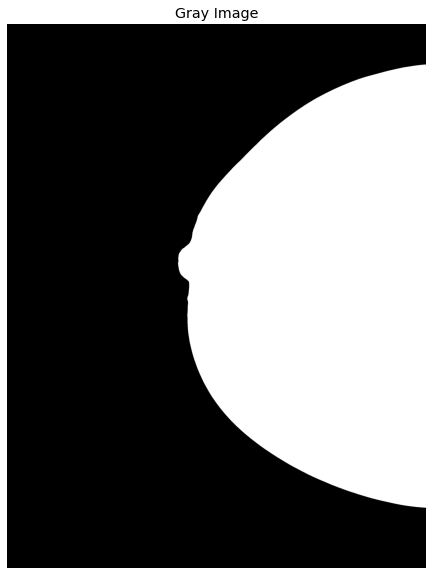

In [ ]:
show(img_mask)

In [ ]:
path_ddsm = "/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/1000_A_1105_1.LEFT_CC.LJPEG.1_highpass.png"
img_ddsm = read_image(path_ddsm)
img_ddsm = img_ddsm.permute(1, 2, 0).numpy()
img_ddsm.shape

(365, 217, 3)

In [ ]:
img_ddsm = np.array(img_ddsm, dtype = np.int64)
img_ddsm=rgb2gray(img_ddsm)
# img_ddsm = preprocess_before_crop(img_ddsm)
# img_equ= histogram_equalization(img_ddsm)
# cdf1 = get_cdf(img_ddsm)
# cdf2 = get_cdf(img_equ)
# show_hist(img_ddsm, img_equ, 'Equalized with numpy', cdf1=cdf1, cdf2=cdf2)

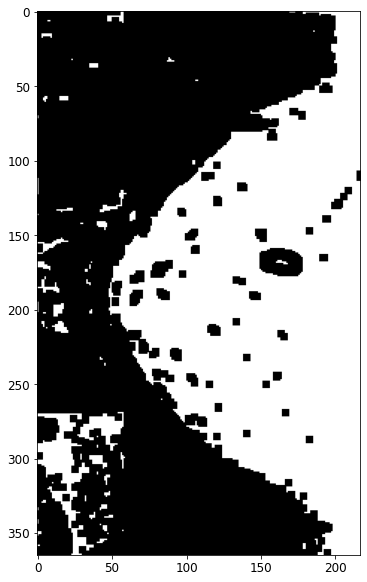

In [ ]:
threshold = filters.threshold_sauvola(img_ddsm)
binary_img = (img_ddsm > threshold)*1
kernel = np.ones((5, 5), np.uint8)
binary_img = binary_img.astype('uint8')
binary_img = cv2.erode(binary_img, kernel, iterations=-2)
show_img(binary_img)

In [ ]:
# binary_img = preprocess_before_crop(binary_img)
# show_img(binary_img)

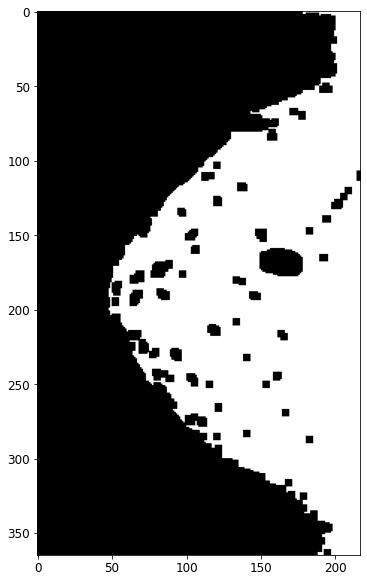

In [ ]:
img_mask_ddsm = get_mask_of_largest_connected_component(binary_img)
show_img(img_mask_ddsm)

In [ ]:
np.unique(img_mask_ddsm)

array([False,  True])

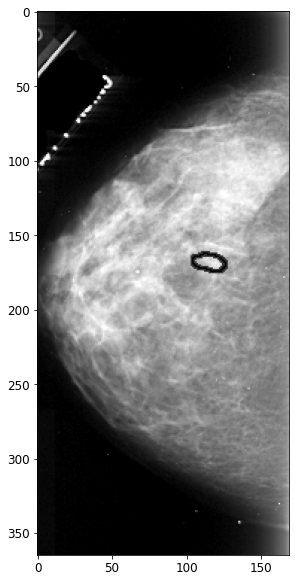

In [ ]:
farest_pixel = np.max(list(zip(*np.where(img_mask_ddsm == 1))), axis=0)
nearest_pixel = np.min(list(zip(*np.where(img_mask_ddsm == 1))), axis=0)
if(nearest_pixel[1] == 0):
    a =  img_ddsm[:farest_pixel[0], :farest_pixel[1]]
else:
    a =  img_ddsm[nearest_pixel[0]:, nearest_pixel[1]:]
show_img(a)

In [ ]:
img_mias = cv2.imread('/kaggle/input/mias-mammography/all-mias/mdb011.pgm')

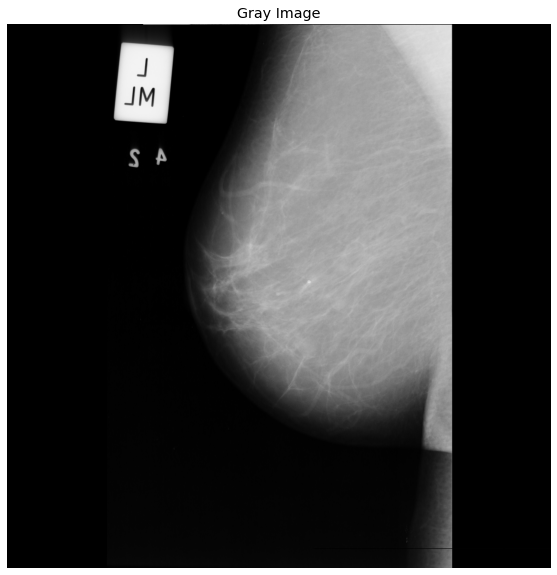

In [ ]:
show(img_mias)

In [ ]:
img_gray_misas = rgb2gray(img_mias)

In [ ]:
img_gray_misas.shape

(1024, 1024)

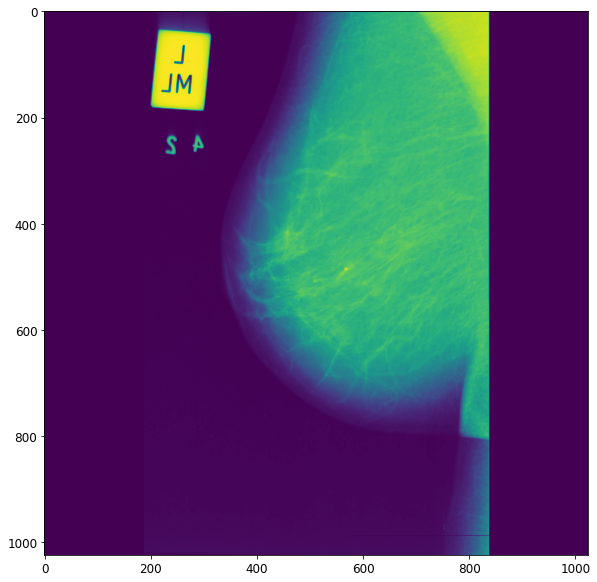

In [ ]:
plt.imshow(img_gray_misas)

In [ ]:
threshold = filters.threshold_sauvola(img_gray_misas)
bin_mias = (img_gray_misas > threshold)*1
kernel = np.ones((5, 5), np.uint8)
bin_mias = bin_mias.astype('uint8')
bin_mias = cv2.erode(bin_mias, kernel, iterations=-2)

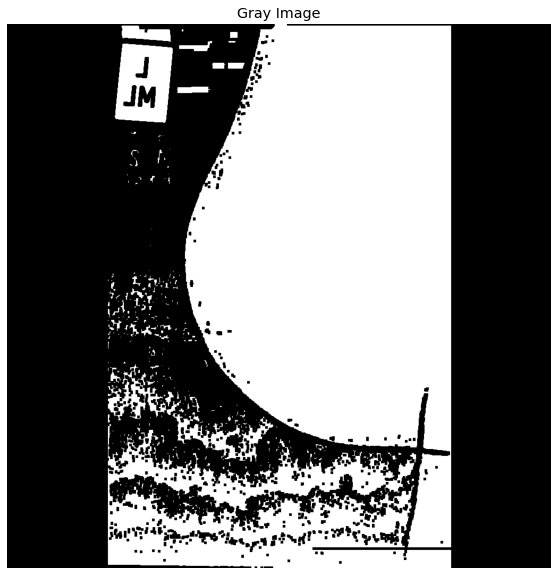

In [ ]:
show(bin_mias)

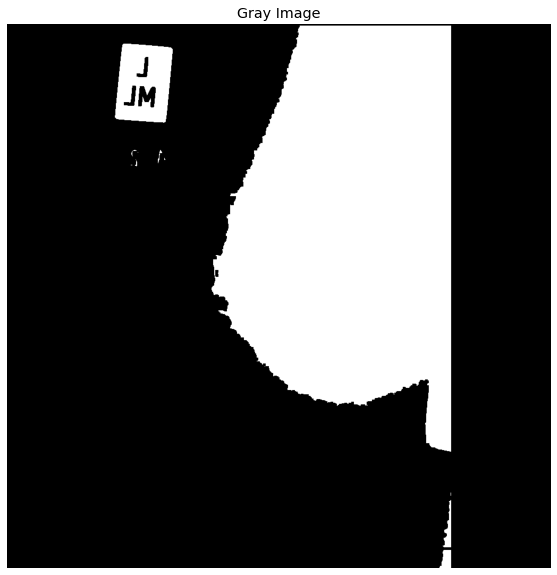

In [ ]:
threshold = filters.threshold_isodata(img_gray_misas)
bin_mias2 = (img_gray_misas > threshold)*1
kernel = np.ones((5, 5), np.uint8)
bin_mias2 = bin_mias2.astype('uint8')
bin_mias2 = cv2.erode(bin_mias2, kernel, iterations=-2)
show(bin_mias2)

In [ ]:
img_mask_mias = get_mask_of_largest_connected_component(bin_mias)
img_mask_mias_2 = get_mask_of_largest_connected_component(bin_mias2)

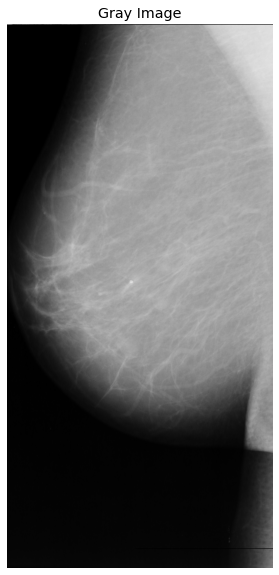

In [ ]:
farest_pixel = np.max(list(zip(*np.where(img_mask_mias == 1))), axis=0)
nearest_pixel = np.min(list(zip(*np.where(img_mask_mias == 1))), axis=0)
if(nearest_pixel[1] == 0):
    a =  img_mias[:farest_pixel[0], :farest_pixel[1]]
else:
    a =  img_mias[nearest_pixel[0]:, nearest_pixel[1]:farest_pixel[1]]
show(a)

In [ ]:
a=rgb2gray(a)
a.shape

(1024, 500)

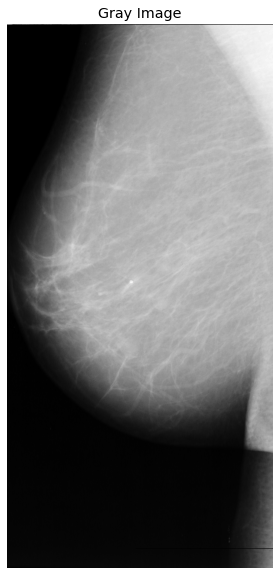

In [ ]:
show(a)

In [ ]:
import numpy as np
import cv2
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torchvision.io import read_image
import matplotlib.pyplot as plt
import pydicom
import torch

In [ ]:
def show(img, title = 'Gray Image', rgb = False, fs = 12, dp = (10, 10)):
    plt.rcParams.update({'font.size': fs})
    plt.rcParams['figure.figsize'] = dp
    if rgb:
        plt.imshow(img[:,:,::-1])
    else:
        plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'{title}')
    plt.show()

In [ ]:
def read_dicom_img(path):
    img = pydicom.dcmread(path)
    img = np.array(img.pixel_array, dtype = np.float32)
    return img, img.shape

In [ ]:
import scipy
import pandas as pd
def get_masks_and_sizes_of_connected_components(img_mask):
    """
    Finds the connected components from the mask of the image
    """
    mask, num_labels = scipy.ndimage.label(img_mask)

    mask_pixels_dict = {}
    for i in range(num_labels+1):
        this_mask = (mask == i)
        if img_mask[this_mask][0] != 0:
            # Exclude the 0-valued mask
            mask_pixels_dict[i] = np.sum(this_mask)

    return mask, mask_pixels_dict


def get_mask_of_largest_connected_component(img_mask):
    """
    Finds the largest connected component from the mask of the image
    """
    mask, mask_pixels_dict = get_masks_and_sizes_of_connected_components(img_mask)
    largest_mask_index = pd.Series(mask_pixels_dict).idxmax()
    largest_mask = mask == largest_mask_index
    return largest_mask

In [ ]:
def Image_procescing_mias(img_mias):
    #readimg
#     img_gray_misas = rgb2gray(img_mias)
    #convert to bin
    threshold = filters.threshold_isodata(img_mias)
    bin_mias = (img_mias > threshold)*1
    kernel = np.ones((5, 5), np.uint8)
    bin_mias = bin_mias.astype('uint8')
    bin_mias = cv2.erode(bin_mias, kernel, iterations=-2)
    #most mask
    img_mask_mias = get_mask_of_largest_connected_component(bin_mias)
    #crop_image
    farest_pixel = np.max(list(zip(*np.where(img_mask_mias == 1))), axis=0)
    nearest_pixel = np.min(list(zip(*np.where(img_mask_mias == 1))), axis=0)
    if(nearest_pixel[1] == 0):
        croped =  img_mias[:farest_pixel[0], :farest_pixel[1]]
    else:
        croped =  img_mias[nearest_pixel[0]:, nearest_pixel[1]:farest_pixel[1]]
    return croped

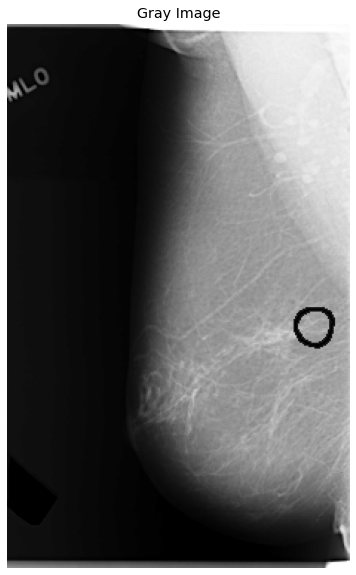

In [ ]:
anh_ddsm = cv2.imread('/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/1017_C_0126_1.RIGHT_MLO.LJPEG.1_highpass.png')
anh_ddsm=rgb2gray(anh_ddsm)
show(anh_ddsm)

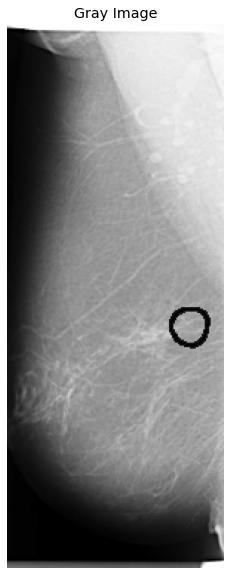

In [ ]:
show(Image_procescing_mias(anh_ddsm))

# Remake Crop function

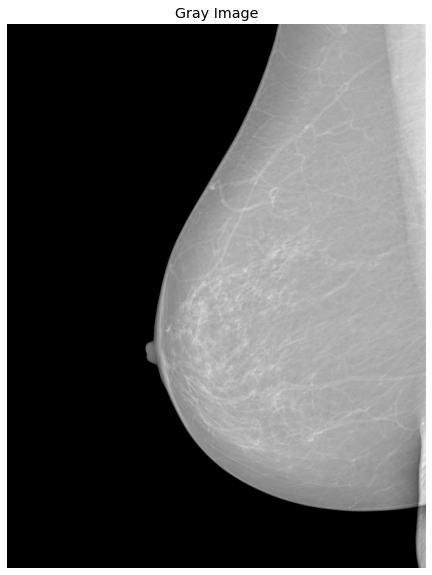

In [ ]:
path_inbreast='/kaggle/input/inbreast2012/INbreast Release 1.0/AllDICOMs/20587346_e634830794f5c1bd_MG_R_ML_ANON.dcm'
img_inbreast, im_shap = read_dicom_img(path_inbreast)
show(img_inbreast )


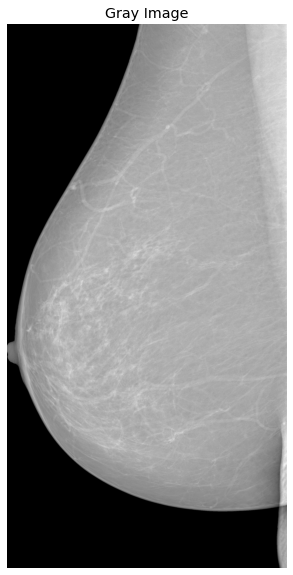

In [ ]:
show(Image_procescing_mias(img_inbreast))

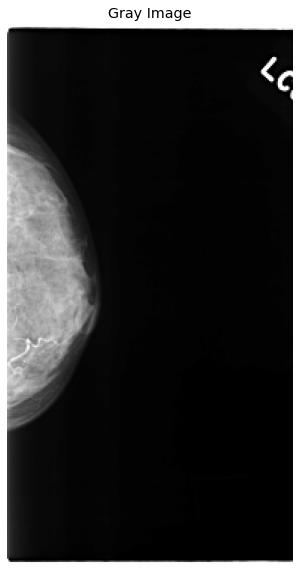

In [ ]:
ddsm_path='/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/1016_C_0125_1.LEFT_CC.LJPEG.1_highpass.png'
img_ddsm=cv2.imread(ddsm_path)
show(img_ddsm)

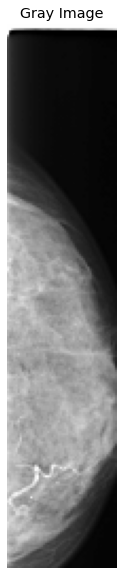

In [ ]:
show(Image_procescing_mias(img_ddsm))

In [ ]:
def Image_procescing(img):
    #check_img_convert_gray
    if len(img.shape)==3:
        img = rgb2gray(img)
    #convert to bin

    threshold = filters.threshold_isodata(img)
    bin_img = (img > threshold)*1
    kernel = np.ones((5, 5), np.uint8)
    bin_img = bin_img.astype('uint8')
    bin_img = cv2.erode(bin_img, kernel, iterations=-2)

    #most mask
    img_mask = get_mask_of_largest_connected_component(bin_img)
    #crop_image

    farest_pixel = np.max(list(zip(*np.where(img_mask == 1))), axis=0)
    nearest_pixel = np.min(list(zip(*np.where(img_mask == 1))), axis=0)
    croped =  img[nearest_pixel[0]:farest_pixel[0], nearest_pixel[1]:farest_pixel[1]]
    return croped

In [ ]:
def show_multi_img(img_list,labels=None,columns=1,rows=1):
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns+rows):
        img = images[i-1]
        label = labels[i-1]
        fig.add_subplot(rows, columns, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img,cmap='gray')
    plt.tight_layout()
    plt.show()

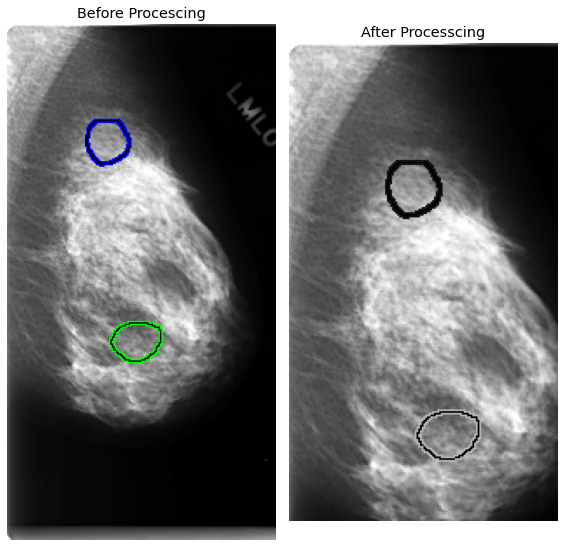

In [ ]:
anhtest=cv2.imread('/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/1074_C_0150_1.LEFT_MLO.LJPEG.1_highpass.png')
images=[anhtest,Image_procescing(anhtest)]
labels=['Before Procescing','After Processcing']
show_multi_img(images,labels,2,1)